In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import os
import tarfile

In [4]:
# Extract the tar.gz file from Google Drive
tar_path = '/content/drive/MyDrive/Senti/aclImdb_v1.tar.gz'
extract_path = '/content/aclImdb'

# Extract the dataset
if not os.path.exists(extract_path):
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path='/content')


In [5]:
import os
import pandas as pd

# Load Data Function
def load_data_from_folder(folder):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            if filename.endswith('.txt'):
                with open(os.path.join(label_folder, filename), 'r', encoding='utf-8') as f:
                    data.append(f.read())
                    labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'text': data, 'label': labels})

# Load training and test data from the extracted folders
train_data = load_data_from_folder('/content/aclImdb/train')
test_data = load_data_from_folder('/content/aclImdb/test')


In [6]:
# Display a sample of positive reviews (label == 1)
print("Positive reviews sample:")
print(train_data[train_data['label'] == 1].sample(5))  # Display 5 random positive reviews

# Display a sample of negative reviews (label == 0)
print("\nNegative reviews sample:")
print(train_data[train_data['label'] == 0].sample(5))  # Display 5 random negative reviews


Positive reviews sample:
                                                    text  label
7895   I'm biased towards any movie that paints a lux...      1
8074   More than just a "kids' movie", "Holes" looks ...      1
4055   This cartoon is short on plot, but is a visual...      1
5930   An interesting thriller that has Paul Winfield...      1
11783  I went to see this movie expecting a nice rela...      1

Negative reviews sample:
                                                    text  label
14466  Well...i was going to wait till this came out ...      0
15405  The actors did a really good job playing their...      0
13368  If you haven't seen ZOMBIE BLOODBATH, you have...      0
20046  Alex D. Linz replaces Macaulay Culkin as the c...      0
17411  OK.... I just have 3 words - cheesy, cheesy an...      0


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


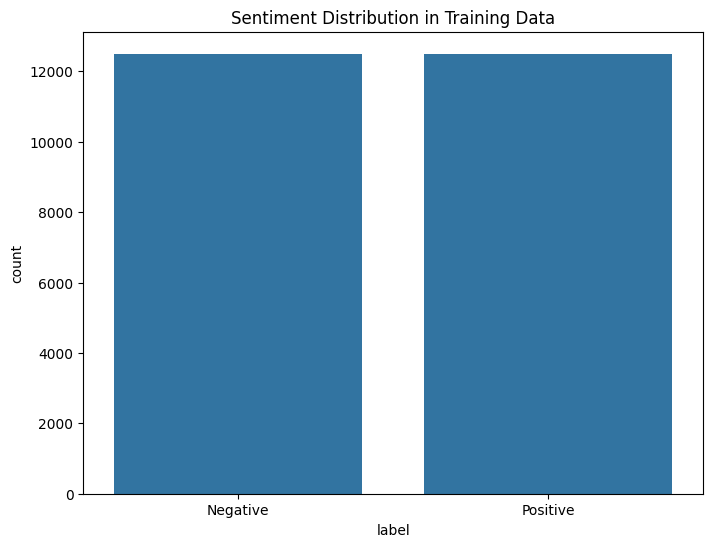

In [8]:
# Count plot for positive and negative reviews
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=train_data)
plt.title('Sentiment Distribution in Training Data')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


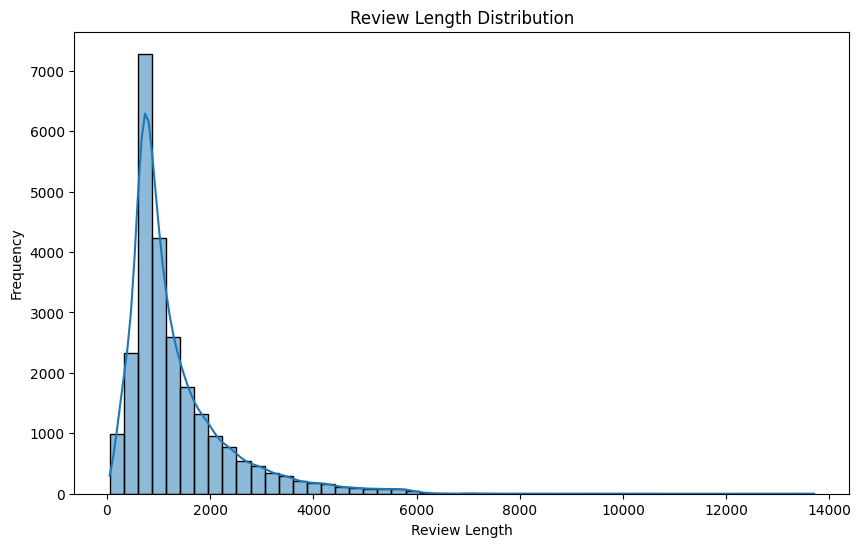

In [9]:
# Add a new column for the length of each review
train_data['review_length'] = train_data['text'].apply(len)

# Plot the review length distribution
plt.figure(figsize=(10,6))
sns.histplot(train_data['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Preprocess Text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [12]:
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

In [14]:
# Print the first 5 samples from the train_data
print(train_data[['text', 'clean_text']].head())

# Print the first 5 samples from the test_data
print(test_data[['text', 'clean_text']].head())


                                                text  \
0  In the classic sense of the four humors (which...   
1  What is most disturbing about this film is not...   
2  My son was 7 years old when he saw this movie,...   
3  Thankfully as a student I have been able to wa...   
4  I was one of about 200 people that was lucky e...   

                                          clean_text  
0  classic sense four humor specific concept funn...  
1  disturbing film school killing spree like one ...  
2  son 7 year old saw movie russian fishing vesse...  
3  thankfully student able watch diagnosis murder...  
4  one 200 people lucky enough see early sneak fi...  
                                                text  \
0  NOROI follows a documentary filmmaker, Masafum...   
1  A twist of fate puts a black man at the head o...   
2  Like those who listened to radio reports about...   
3  This story about a man's 28 year struggle for ...   
4  House of Dracula was made towards the end of U... 

In [13]:
MAX_NB_WORDS = 10000  # Maximum number of words in the tokenizer
MAX_SEQUENCE_LENGTH = 200  # Maximum sequence length for padding


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:


# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

# Fit tokenizer on training data
tokenizer.fit_on_texts(train_data['clean_text'])


In [16]:
# Convert texts to sequences for train and test data
X_train = tokenizer.texts_to_sequences(train_data['clean_text'])
X_test = tokenizer.texts_to_sequences(test_data['clean_text'])

# Pad sequences to ensure all have the same length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)


In [18]:
# Extract the labels from the dataset
y_train = train_data['label'].values
y_test = test_data['label'].values


In [19]:
# Print sample of tokenized and padded sequences for training data
print("Sample padded sequence from X_train:\n", X_train[0])  # First padded sequence
print("\nOriginal cleaned text for comparison:\n", train_data['clean_text'].iloc[0])


Sample padded sequence from X_train:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  226  190  593  386 2848  891   81   10  609
 7814 3047 1223  386   75   81  355   25  127 5583  499 9133 7685    8
 4808  698 1659   32  612  873 8103  732  390  758  127  577  756    5
 2879  820  274    5 6780 3398   98 1892 2806 7192 7944 1426 6867 1638
 2889 2880   10   35  158  718 1235 6242    8 2983 3399 2553 3702  689
 1215   87  127    8 1158 6415  463 4978 2984 5017 2113 7193    8   57
  136 2589 2630 3129 1306  386 3047  13

In [20]:
# Print first few labels from the training data
print("Sample labels from y_train:", y_train[:5])


Sample labels from y_train: [1 1 1 1 1]


In [21]:
# KFold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    # Split into training and validation sets for the fold
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    # Build the ANN Model
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification

    # Compile the model
    optimizer = Adam(learning_rate=0.001)  # Adjust learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

    # Train the model
    history = model.fit(X_fold_train, y_fold_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_fold_val, y_fold_val),
                        callbacks=[early_stopping, reduce_lr])

        # Evaluate the model on validation data
    y_fold_pred = (model.predict(X_fold_val) > 0.5).astype("int32")  # Predict and threshold to 0/1
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    fold_accuracies.append(fold_accuracy)

    # Print the accuracy for this fold
    print(f'Fold Accuracy: {fold_accuracy:.4f}')



Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6234 - loss: 0.6077 - val_accuracy: 0.8662 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9082 - loss: 0.2488 - val_accuracy: 0.8834 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9468 - loss: 0.1601 - val_accuracy: 0.8712 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9667 - loss: 0.0993 - val_accuracy: 0.8732 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9834 - loss: 0.0568 - val_accuracy: 0.8692 - val_loss: 0.4999 - learning_rate: 5.0000e-04
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold Accuracy: 0.8834
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6592 - loss: 0.5753 - val_accuracy: 0.8616 - val_loss: 0.3214 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9191 - loss: 0.2287 - val_accuracy: 0.8652 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9497 - loss: 0.1521 - val_accuracy: 0.8656 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9724 - loss: 0.0914 - val_accuracy: 0.8596 - val_loss: 0.5148 - learning_rate: 5.0000e-04
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold Accuracy: 0.8616
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6307 - loss: 0.6154 - val_accuracy: 0.8620 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9044 - loss: 0.2621 - val_accuracy: 0.8732 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9479 - loss: 0.1523 - val_accuracy: 0.8638 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9634 - loss: 0.1090 - val_accuracy: 0.8604 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9816 - loss: 0.0631 - val_accuracy: 0.8616 - val_loss: 0.4953 - learning_rate: 5.0000e-04
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold Accuracy: 0.8732
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6434 - loss: 0.5859 - val_accuracy: 0.8672 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9108 - loss: 0.2453 - val_accuracy: 0.8780 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9472 - loss: 0.1546 - val_accuracy: 0.8582 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9713 - loss: 0.0877 - val_accuracy: 0.8684 - val_loss: 0.4216 - learning_rate: 5.0000e-04
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold Accuracy: 0.8672
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6246 - loss: 0.6144 - val_accuracy: 0.8724 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9031 - loss: 0.2593 - val_accuracy: 0.8802 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9471 - loss: 0.1573 - val_accuracy: 0.8766 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9686 - loss: 0.1015 - val_accuracy: 0.8752 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9865 - loss: 0.0516 - val_accuracy: 0.8686 - val_loss: 0.5040 - learning_rate: 5.0000e-04
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold Accuracy: 0.8802


In [25]:
# Average Accuracy
print(f'Average Accuracy across folds: {np.mean(fold_accuracies):.4f}')

# Final Evaluation on Test Data
final_model = model  # Optionally, you could retrain on the full dataset before this
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")

# Print Accuracy and Classification Report for Test Data
print(f'Final Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}')
print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive']))



Average Accuracy across folds: 0.8731
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Final Test Accuracy: 0.8582
              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86     12500
    Positive       0.88      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



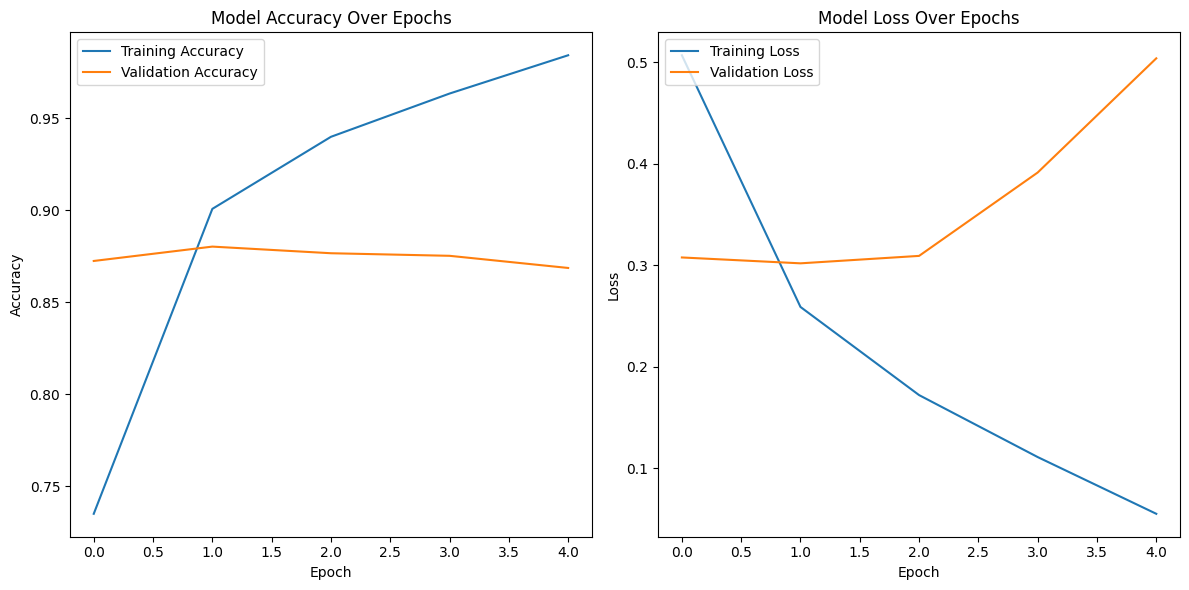

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with your history object (from model.fit)
plot_training_history(history)


In [27]:
# Save the model to an .h5 file
model.save('sentiment_analysis_model.keras')


In [30]:
from keras.models import load_model

# Load the model
loaded_model = load_model('sentiment_analysis_model.keras')


In [31]:
import string
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences

# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Preprocess the text (same preprocessing function used earlier)
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = nltk.WordNetLemmatizer()

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Tokenizer was fit on the training data, use it for your custom input
def prepare_input_for_model(text, tokenizer, max_sequence_length=200):
    processed_text = preprocess_text(text)  # Preprocess the input
    sequences = tokenizer.texts_to_sequences([processed_text])  # Tokenize the input
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)  # Pad sequences
    return padded_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# Sample review (positive or negative)
sample_review = "The characters were one-dimensional and unlikeable."

# Preprocess and prepare the sample review
sample_input = prepare_input_for_model(sample_review, tokenizer)

# Predict the sentiment (probability of being positive)
prediction = loaded_model.predict(sample_input)

# Convert the prediction to positive or negative (threshold at 0.5)
sentiment = "Positive" if prediction > 0.5 else "Negative"
print(f"The sentiment of the review is: {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
The sentiment of the review is: Negative


In [33]:
# Sample review (positive or negative)
sample_review = "This movie was a masterpiece!"

# Check if the sample review is longer than 100 characters
if len(sample_review) > 50:
    # Preprocess and prepare the sample review
    sample_input = prepare_input_for_model(sample_review, tokenizer)

    # Predict the sentiment (probability of being positive)
    prediction = loaded_model.predict(sample_input)

    # Convert the prediction to positive or negative (threshold at 0.5)
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"The sentiment of the review is: {sentiment}")
else:
    print("The review is not long enough. Please provide a review with more than 100 characters.")


The review is not long enough. Please provide a review with more than 100 characters.
